In [1]:
# 데이터 전처리, 데이터 증강
import matplotlib.pyplot as plt
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor

In [2]:
# 데이터셋 불러오기
training_dataset = CIFAR10(
    root = './',
    train = True,
    download = True,
    transform = ToTensor()
)

test_dataset = CIFAR10(
    root = './',
    train = False,
    download = True,
    transform = ToTensor()
)

In [3]:
training_dataset[0][0].size()

torch.Size([3, 32, 32])

In [4]:
training_dataset[0][0].view(32,32,3).size()

torch.Size([32, 32, 3])

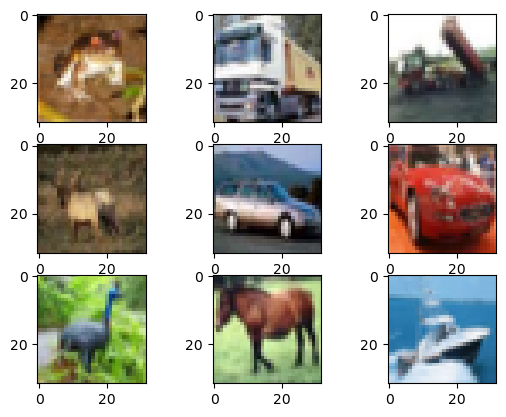

In [5]:
for i in range(9):
    img, label = training_dataset[i]
    plt.subplot(3,3,i+1)
    plt.imshow(img.permute(1,2,0))  #(C,H,W):0 1 2 -- 1 2 0   (H,W,C)
plt.show()  

for i in range(9):
    img, label = training_dataset[i]
    plt.subplot(3,3,i+1)
    plt.imshow(img.permute(1,2,0)) #(C,H,W): 0,1,2 -- 1 2 0 (H,W,C)
plt.show()

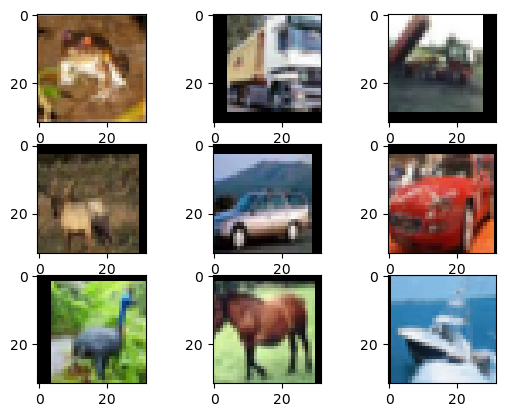

In [6]:
# 크롭핑과 뒤집기 추가
import torchvision.transforms as T
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop

transform = Compose([
    T.ToTensor(),
    RandomCrop((32,32),padding=4),
    RandomHorizontalFlip(p=0.5)
    ])

# 데이터셋 불러오기
training_dataset = CIFAR10(
    root = './',
    train = True,
    download = True,
    transform = transform
)

test_dataset = CIFAR10(
    root = './',
    train = False,
    download = True,
    transform = transform
)

for i in range(9):
    img, label = training_dataset[i]
    plt.subplot(3,3,i+1)
    plt.imshow(img.permute(1,2,0)) #(C,H,W): 0,1,2 -- 1 2 0 (H,W,C)
plt.show()

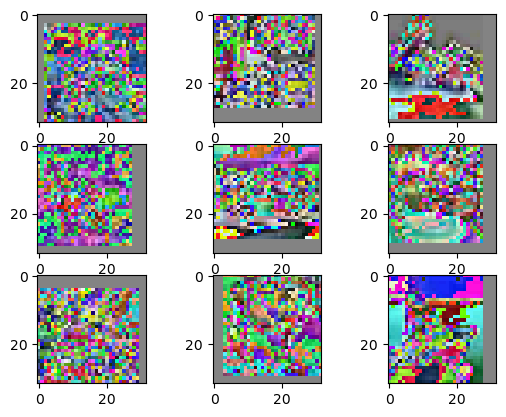

In [7]:
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize
# 데이터 전처리에 정규화를 추가

transform = Compose([
    T.ToPILImage(),
    RandomCrop((32,32),padding=4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    # 데이터 정규화
    Normalize((0.5,0.5,0.5),(0.2,0.2,0.2)),
    T.ToPILImage()
    ])

training_dataset = CIFAR10(
    root = './',
    train = True,
    download = True,
    transform = transform
)

test_dataset = CIFAR10(
    root = './',
    train = False,
    download = True,
    transform = transform
)

for i in range(9):
    # img, label = training_dataset[i]
    plt.subplot(3,3,i+1)
    # plt.imshow(img.permute(1,2,0)) #(C,H,W): 0,1,2 -- 1 2 0 (H,W,C)
    plt.imshow(transform(training_dataset.data[i]))
plt.show()

In [8]:
import torch.nn as nn
class BasicBlock(nn.Module):
    def __init__(self, int_channels, out_channels, hidden_dim):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(int_channels, hidden_dim, kernel_size =3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels, kernel_size =3, padding=1)
        self.relu = nn.ReLU()
        self.pool =nn.MaxPool2d(2)
    def forward(self, X):
        X = self.relu(self.conv1(X))
        X = self.relu(self.conv2(X))
        out = self.pool(X)
        return out

In [9]:
#특성잡음
import torch
class CNN(nn.Module):
    def __init__(self,num_class):
        super(CNN,self).__init__()
        self.block1 = BasicBlock(3,64,64) # c c p (3,32,32) (64,32,32) (64,32,32 ), (64,16,16)
        self.block2 = BasicBlock(64,128,128) 
        # 분류기        
        self.fc1 = nn.Linear(128*8*8, 2048)
        self.fc2 = nn.Linear(2048 , 256) 
        self.fc3 = nn.Linear( 256, num_class)
        self.relu = nn.ReLU()             
    def forward(self, X):
        X = self.block1(X)
        X = self.block2(X)
        #(-1,128*8*8)
        X = torch.flatten(X,start_dim=1)
        X = self.relu(self.fc1(X))
        X = self.relu(self.fc2(X))
        out = self.fc3(X)
        return out        
    

In [10]:
#샘플데이터 생성해서 구조 확인
X = torch.randn(4,3,32,32)
model= CNN(10)
model(X)

tensor([[ 0.0234,  0.0116,  0.0360, -0.0058, -0.0068, -0.0205,  0.0042,  0.0159,
          0.0005,  0.0535],
        [ 0.0186,  0.0112,  0.0325, -0.0036, -0.0063, -0.0181, -0.0010,  0.0108,
         -0.0008,  0.0527],
        [ 0.0215,  0.0087,  0.0304, -0.0063, -0.0057, -0.0206,  0.0012,  0.0138,
         -0.0019,  0.0523],
        [ 0.0218,  0.0109,  0.0338, -0.0064, -0.0059, -0.0199,  0.0004,  0.0115,
         -0.0021,  0.0539]], grad_fn=<AddmmBackward0>)

In [11]:
from torch.utils.data.dataloader import DataLoader
# 데이터 증강

transform = Compose([
    RandomCrop((32,32),padding=4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    # 데이터 정규화
    Normalize((0.5,0.5,0.5),(0.2,0.2,0.2)),
    ])
#데이터 셋
# 데이터셋 불러오기
training_dataset = CIFAR10(root = './',train = True,download = True,transform = ToTensor())
test_dataset = CIFAR10(root = './',train = False, download = True,transform = ToTensor() )
# 데이터 로더
train_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN(10)
model.to(device)


CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=8192, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)

In [12]:
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [13]:
from torchsummary import summary
model = CNN(10)
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
        BasicBlock-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
             ReLU-10          [-1, 128, 16, 16]               0
        MaxPool2d-11            [-1, 128, 8, 8]               0
       BasicBlock-12            [-1, 128, 8, 8]               0
           Linear-13                 [-1, 2048]      16,779,264
             ReLU-14                 [-

In [14]:
for name, param in model.named_parameters(): 
    print(f'{name} {list(param.shape)}')

block1.conv1.weight [64, 3, 3, 3]
block1.conv1.bias [64]
block1.conv2.weight [64, 64, 3, 3]
block1.conv2.bias [64]
block2.conv1.weight [128, 64, 3, 3]
block2.conv1.bias [128]
block2.conv2.weight [128, 128, 3, 3]
block2.conv2.bias [128]
fc1.weight [2048, 8192]
fc1.bias [2048]
fc2.weight [256, 2048]
fc2.bias [256]
fc3.weight [10, 256]
fc3.bias [10]


In [15]:
# 레이어 접근 가능하고 변경 가능하다
# model.fc3 =nn.Linear(in_features=256, out_features=2, bias=True)

In [20]:
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
from torch.optim import Adam
# 데이터 증강

transform = Compose([
    RandomCrop((32,32),padding=4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    # 데이터 정규화
    Normalize((0.5,0.5,0.5),(0.2,0.2,0.2)),
    ])
#데이터 셋
# 데이터셋 불러오기
training_dataset = CIFAR10(root = './',train = True,download = True,transform = ToTensor())
test_dataset = CIFAR10(root = './',train = False, download = True,transform = ToTensor() )
# 데이터 로더
train_loader = DataLoader(training_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN(10)
model.to(device)

lr = 1e-3
optim = Adam(model.parameters(), lr=lr)
epochs = 1
# 학습루프
for epoch in range(epochs):
    for data, label in tqdm(train_loader,desc=f'epoch:{epoch+1}'):
        optim.zero_grad()
        preds = model(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optim.step()
    if (epoch+1) % 10 ==0:
        print(f'epoch : {epoch+1} loss : {loss.item()} ')
#모델저장
torch.save(model.state_dict(), 'cifar.pth')

epoch:1: 100%|██████████| 196/196 [03:49<00:00,  1.17s/it]


In [23]:
#평가
model.load_state_dict(torch.load('cifar.pth',map_location=device))
#예측
num_corr = 0
with torch.no_grad():
    for data, label in test_loader:
        output = model(data.to(device))
        preds = output.data.max(1)[1]
        corr = preds.eq(label.to(device).data).sum().item()
        num_corr += corr
    print(f'Accuracy : {num_corr / len(test_loader)}')

Accuracy : 118.55


파이토치
모델+가중치
가중치만

```
data
    train
        class1
            img1.jpg
            img2.jpg
            ...
        class2
            img1.jpg
            img2.jpg
            
    test
        class1
            img1.jpg
            img2.jpg
            ...
        class2
            img1.jpg
            img2.jpg


In [28]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
transform  = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
train_dataset = datasets.ImageFolder(root = r'D:\skn_20\deep-learning\train', transform=transform)
test_dataset = datasets.ImageFolder(root = r'D:\skn_20\deep-learning\test', transform=transform)
train_loader = DataLoader(train_dataset,batch_size=5,shuffle= True )
test_loader = DataLoader(train_dataset,batch_size=5, shuffle =False  )

In [29]:
img, label = next(iter(train_loader))
label

tensor([1, 1, 1, 1, 1])